In [73]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle
import re
import datetime as dt

from pybaseball import *

from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import psycopg2
import pandas.io.sql as psql
from sqlalchemy import create_engine

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 200)


In [413]:
df_18 = pd.read_pickle('../pickles/2018_games_labeled_1.pkl')
df_17 = pd.read_pickle('../pickles/2017_games_labeled_1.pkl')
df_16 = pd.read_pickle('../pickles/2016_games_labeled_1.pkl')
df_15 = pd.read_pickle('../pickles/2015_games_labeled_1.pkl')
merge = pd.read_pickle('../pickles/labeled_games_agg.pkl')

In [414]:
df_18.head()

,#days,2b,3b,ab,age,appearance_yr,babip,bb,bf,cs,date,days,days_preceeding,days_rest,enddate,er,era,first_x,first_y,g,gb/fb,gdp,gs,h,hbp,hr,ibb,injured?,injury,ip,key_bbref_x,key_bbref_y,key_fangraphs_x,key_fangraphs_y,key_mlbam,key_retro_x,key_retro_y,l,last_x,last_y,ld,lev,list,mlb_played_first_x,mlb_played_first_y,mlb_played_last_x,mlb_played_last_y,moneyearned,name_first_x,name_first_y,name_last_x,name_last_y,name_x,name_y,pit,po,posititon,pu,r,sb,sf,so,so/w,so9,startdate,stl,str,sts,sv,team,tm,w,whip,year
95,368.0,0.0,0.0,23.0,45.0,1,0.333,1.0,24.0,0.0,2018-04-02,9.0,144,182.0,9/1,1.0,1.50,bartolocolon,bartolo,1.0,0.55,1.0,1.0,7.0,0.0,1.0,0.0,0.0,Back,6.0,colonba01,colonba01,375.0,375.0,112526.0,colob001,colob001,NaN,bartolocolon,colon,0.10,MLB-AL,10,1997.0,1997.0,2018.0,2018.0,84681,bartolo,bartolo,colon,colon,bartolocolon,bartolocolon,89.0,0.0,SP,0.05,1.0,0.0,0.0,4.0,4.0,6.0,2018-08-24,0.21,0.70,0.07,NaN,TEX,Texas,NaN,1.333,2018.0
96,362.0,0.0,0.0,7.0,45.0,2,0.333,0.0,7.0,0.0,2018-04-08,9.0,138,6.0,9/1,0.0,0.00,bartolocolon,bartolo,1.0,1.00,0.0,0.0,1.0,0.0,0.0,0.0,0.0,Back,2.0,colonba01,colonba01,375.0,375.0,112526.0,colob001,colob001,NaN,bartolocolon,colon,0.00,MLB-AL,10,1997.0,1997.0,2018.0,2018.0,84681,bartolo,bartolo,colon,colon,bartolocolon,bartolocolon,29.0,0.0,SP,0.00,0.0,0.0,0.0,4.0,NaN,18.0,2018-08-24,0.24,0.72,0.14,NaN,TEX,Texas,NaN,0.500,2018.0
97,360.0,0.0,0.0,9.0,45.0,3,0.250,0.0,10.0,0.0,2018-04-10,9.0,136,2.0,9/1,1.0,3.00,bartolocolon,bartolo,1.0,0.38,0.0,0.0,2.0,0.0,0.0,0.0,0.0,Back,3.0,colonba01,colonba01,375.0,375.0,112526.0,colob001,colob001,NaN,bartolocolon,colon,0.25,MLB-AL,10,1997.0,1997.0,2018.0,2018.0,84681,bartolo,bartolo,colon,colon,bartolocolon,bartolocolon,29.0,0.0,SP,0.00,1.0,0.0,1.0,2.0,NaN,6.0,2018-08-24,0.14,0.66,0.10,NaN,TEX,Texas,NaN,0.667,2018.0
98,355.0,1.0,0.0,23.0,45.0,4,0.059,1.0,25.0,0.0,2018-04-15,9.0,131,5.0,9/1,1.0,1.17,bartolocolon,bartolo,1.0,0.59,0.0,1.0,1.0,0.0,0.0,0.0,0.0,Back,7.2,colonba01,colonba01,375.0,375.0,112526.0,colob001,colob001,NaN,bartolocolon,colon,0.18,MLB-AL,10,1997.0,1997.0,2018.0,2018.0,84681,bartolo,bartolo,colon,colon,bartolocolon,bartolocolon,96.0,0.0,SP,0.00,1.0,0.0,1.0,7.0,7.0,8.2,2018-08-24,0.24,0.69,0.08,NaN,TEX,Texas,NaN,0.261,2018.0
99,349.0,0.0,0.0,22.0,45.0,5,0.300,1.0,25.0,1.0,2018-04-21,9.0,125,6.0,9/1,4.0,6.35,bartolocolon,bartolo,1.0,0.52,0.0,1.0,7.0,1.0,1.0,0.0,0.0,Back,5.2,colonba01,colonba01,375.0,375.0,112526.0,colob001,colob001,NaN,bartolocolon,colon,0.24,MLB-AL,10,1997.0,1997.0,2018.0,2018.0,84681,bartolo,bartolo,colon,colon,bartolocolon,bartolocolon,85.0,0.0,SP,0.00,4.0,0.0,1.0,2.0,2.0,3.2,2018-08-24,0.21,0.69,0.08,NaN,TEX,Texas,NaN,1.412,2018.0


In [415]:
sc_18 = pd.read_pickle('../pickles/sc_2018_unclean.pkl')
sc_17 = pd.read_pickle('../pickles/sc_2017_unclean.pkl')
sc_16 = pd.read_pickle('../pickles/sc_2016_unclean.pkl')
sc_15 = pd.read_pickle('../pickles/sc_2015_unclean.pkl')
total = sc_18.append([sc_17, sc_16, sc_15])
total = total.sort_values(by=['key_mlbam', 'date'])
total = total.set_index(np.arange(len(total)))
total

,#days,2b,3b,ab,age,appearance_yr,babip,bb,bf,cs,date,days,days_preceeding,days_rest,enddate,er,era,first_x,first_y,g,gb/fb,gdp,gs,h,hbp,hr,ibb,injured?,injury,ip,key_bbref_x,key_bbref_y,key_fangraphs_x,key_fangraphs_y,key_mlbam,key_retro_x,key_retro_y,l,last_x,last_y,ld,lev,list,mlb_played_first_x,mlb_played_first_y,mlb_played_last_x,mlb_played_last_y,moneyearned,name_first_x,name_first_y,name_last_x,name_last_y,name_x,name_y,pit,po,posititon,pu,r,sb,sf,so,so/w,so9,startdate,stl,str,sts,sv,team,tm,w,whip,year,fb_count,p_throws_x,fb_release_speed,fb_percieved_speed,fb_spin_rate,fb_avg_x,fb_avg_z,fb_avg_extension,fb_x_movement,fb_z_movement,os_count,p_throws_y,os_release_speed,os_percieved_speed,os_spin_rate,os_avg_x,os_avg_z,os_avg_extension,os_x_movement,os_z_movement
0,1460.0,0.0,0.0,22.0,42.0,1,0.154,1.0,23.0,0.0,2015-04-06,NaN,792,182.0,NaN,1.0,1.500000,bartolocolon,NaN,1.0,0.64,0.0,1.0,3.0,0.0,1.0,0.0,0.0,NaN,6.0,colonba01,NaN,375.0,NaN,112526.0,colob001,NaN,NaN,bartolocolon,NaN,0.07,MLB-NL,NaN,1997.0,NaN,2018.0,NaN,NaN,bartolo,NaN,colon,NaN,bartolocolon,NaN,86.0,0.0,NaN,0.07,1.0,0.0,0.0,8.0,8.00,12.0,2017-06-06,0.21,0.69,0.15,NaN,NaN,New York,1.0,0.667,NaN,76,R,89.7842,88.2026,2280.71,-1.48172,5.91654,5.60574,-1.02622,1.27685,10,R,83.54,81.5966,2469.44,-1.73399,5.99212,5.26267,0.0466025,0.628567
1,1454.0,1.0,1.0,27.0,42.0,2,0.238,0.0,27.0,0.0,2015-04-12,NaN,786,6.0,NaN,3.0,3.860000,bartolocolon,NaN,1.0,0.33,0.0,1.0,6.0,0.0,1.0,0.0,0.0,NaN,7.0,colonba01,NaN,375.0,NaN,112526.0,colob001,NaN,NaN,bartolocolon,NaN,0.33,MLB-NL,NaN,1997.0,NaN,2018.0,NaN,NaN,bartolo,NaN,colon,NaN,bartolocolon,NaN,77.0,0.0,NaN,0.05,3.0,0.0,0.0,5.0,NaN,6.4,2017-06-06,0.21,0.78,0.06,NaN,NaN,New York,1.0,0.857,NaN,71,R,88.569,86.3274,2133.97,-1.16116,5.9567,5.04944,-0.843298,1.23725,6,R,82,80.0865,1761.83,-1.35745,6.00008,4.996,-0.546108,0.733678
2,1449.0,2.0,0.0,26.0,42.0,3,0.250,0.0,26.0,0.0,2015-04-17,NaN,781,5.0,NaN,1.0,1.290000,bartolocolon,NaN,1.0,0.43,1.0,1.0,6.0,0.0,1.0,0.0,0.0,NaN,7.0,colonba01,NaN,375.0,NaN,112526.0,colob001,NaN,NaN,bartolocolon,NaN,0.29,MLB-NL,NaN,1997.0,NaN,2018.0,NaN,NaN,bartolo,NaN,colon,NaN,bartolocolon,NaN,91.0,0.0,NaN,0.05,1.0,0.0,0.0,5.0,NaN,6.4,2017-06-06,0.21,0.73,0.05,NaN,NaN,New York,1.0,0.857,NaN,76,R,89.2461,87.102,2193.35,-1.29515,6.12479,5.37295,-1.08747,1.03818,15,R,82.94,80.8483,1817.46,-1.52015,6.10517,5.2042,-0.449991,0.594358
3,1443.0,2.0,0.0,23.0,42.0,4,0.368,0.0,24.0,1.0,2015-04-23,NaN,775,6.0,NaN,3.0,4.500000,bartolocolon,NaN,1.0,0.22,1.0,1.0,7.0,0.0,0.0,0.0,0.0,NaN,6.0,colonba01,NaN,375.0,NaN,112526.0,colob001,NaN,NaN,bartolocolon,NaN,0.33,MLB-NL,NaN,1997.0,NaN,2018.0,NaN,NaN,bartolo,NaN,colon,NaN,bartolocolon,NaN,88.0,0.0,NaN,0.11,3.0,0.0,1.0,5.0,NaN,7.5,2017-06-06,0.23,0.66,0.07,NaN,NaN,New York,1.0,1.167,NaN,80,R,89.025,86.7799,2196.47,-1.22738,6.09687,5.24317,-1.29272,1.11685,11,R,81.9364,79.716,2036.36,-1.43826,6.18081,5.08982,-0.711843,0.584264
4,1437.0,2.0,0.0,26.0,42.0,5,0.333,0.0,29.0,0.0,2015-04-29,NaN,769,6.0,NaN,4.0,5.400000,bartolocolon,NaN,1.0,0.48,1.0,1.0,9.0,0.0,1.0,0.0,0.0,NaN,6.2,colonba01,NaN,375.0,NaN,112526.0,colob001,NaN,1.0,bartolocolon,NaN,0.28,MLB-NL,NaN,1997.0,NaN,2018.0,NaN,NaN,bartolo,NaN,colon,NaN,bartolocolon,NaN,91.0,0.0,NaN,0.04,4.0,0.0,1.0,2.0,NaN,2.7,2017-06-06,0.26,0.70,0.03,NaN,NaN,New York,NaN,1.350,NaN,72,R,88.4625,86.0994,2192.56,-0.902362,6.5241,5.15831,-1.21026,1.22752,17,R,82.4765,79.9319,2331.31,-1.20868,6.4466,4.90069,-0.0175206,0.677131
5,1431.0,0.0,0.0,29.0,42.0,6,0.263,0.0,29.0,0.0,2015-05-05,NaN,763,6.0,NaN,1.0,1.170000,bartolocolon,NaN,1.0,0.30,0.0,1.0,6.0,0.0,1.0,0.0,0.0,NaN,7.2,colonba01,NaN,375.0,NaN,112526.0,colob001,NaN,NaN,bartolocolon,NaN,0.35,MLB-NL,NaN,1997.0,NaN,2018.0,NaN,NaN,bartolo,NaN,colon,NaN,bartolocolon,NaN,97.0,0.0,NaN,0.15,1.0,0.0,0.0,9.0,NaN,10.6,2017-06-06,0.27,0.73,0.08,NaN,NaN,New York,1.0,0.783,NaN,75,R,88.4733,86.1686,2127.81,-1.32471,6.09052,5.34588,-1.25803,0.782793,22,R,82.8591,80.5772,2202.27,-1.46256,6.19927,5.15359,-0.2

In [416]:
drop = ['#days', '2b', '3b', 'ab', 'babip', 'bf', 'cs', 'date', 'days', 'days_preceeding', 'enddate', 'era', 'first_x', 'first_y', 'g', 'gb/fb', 'gdp', 'gs', 'ibb', 'injury', 'key_bbref_x', 'key_bbref_y', 'key_fangraphs_x', 'key_fangraphs_y', 'key_mlbam', 'key_retro_x', 'key_retro_y', 'l', 'last_x', 'last_y', 'ld', 'lev', 'list', 'mlb_played_first_y', 'mlb_played_last_x', 'mlb_played_last_y', 'moneyearned', 'name_first_x', 'name_first_y', 'name_last_x', 'name_last_y', 'name_x', 'name_y', 'po', 'posititon', 'pu', 'sb', 'sf', 'so/w', 'startdate', 'stl', 'sts', 'sv', 'team', 'tm', 'year']

In [417]:
X = total.drop(columns=drop)
X = X.replace([np.inf, -np.inf], np.nan)
X

,age,appearance_yr,bb,days_rest,er,h,hbp,hr,injured?,ip,mlb_played_first_x,pit,r,so,so9,str,w,whip,fb_count,p_throws_x,fb_release_speed,fb_percieved_speed,fb_spin_rate,fb_avg_x,fb_avg_z,fb_avg_extension,fb_x_movement,fb_z_movement,os_count,p_throws_y,os_release_speed,os_percieved_speed,os_spin_rate,os_avg_x,os_avg_z,os_avg_extension,os_x_movement,os_z_movement
0,42.0,1,1.0,182.0,1.0,3.0,0.0,1.0,0.0,6.0,1997.0,86.0,1.0,8.0,12.0,0.69,1.0,0.667,76.0,R,89.784211,88.202553,2280.710526,-1.481718,5.916537,5.605737,-1.026215,1.276848,10.0,R,83.540000,81.596556,2469.444444,-1.733989,5.992122,5.262667,0.046602,0.628567
1,42.0,2,0.0,6.0,3.0,6.0,0.0,1.0,0.0,7.0,1997.0,77.0,3.0,5.0,6.4,0.78,1.0,0.857,71.0,R,88.569014,86.327366,2133.971831,-1.161156,5.956703,5.049437,-0.843298,1.237249,6.0,R,82.000000,80.086500,1761.833333,-1.357450,6.000083,4.996000,-0.546108,0.733678
2,42.0,3,0.0,5.0,1.0,6.0,0.0,1.0,0.0,7.0,1997.0,91.0,1.0,5.0,6.4,0.73,1.0,0.857,76.0,R,89.246053,87.101987,2193.346667,-1.295146,6.124792,5.372947,-1.087467,1.038179,15.0,R,82.940000,80.848267,1817.461538,-1.520147,6.105167,5.204200,-0.449991,0.594358
3,42.0,4,0.0,6.0,3.0,7.0,0.0,0.0,0.0,6.0,1997.0,88.0,3.0,5.0,7.5,0.66,1.0,1.167,80.0,R,89.025000,86.779882,2196.473684,-1.227378,6.096868,5.243171,-1.292720,1.116850,11.0,R,81.936364,79.716000,2036.363636,-1.438264,6.180809,5.089818,-0.711843,0.584264
4,42.0,5,0.0,6.0,4.0,9.0,0.0,1.0,0.0,6.2,1997.0,91.0,4.0,2.0,2.7,0.70,NaN,1.350,72.0,R,88.462500,86.099380,2192.563380,-0.902362,6.524101,5.158310,-1.210262,1.227521,17.0,R,82.476471,79.931938,2331.312500,-1.208682,6.446600,4.900688,-0.017521,0.677131
5,42.0,6,0.0,6.0,1.0,6.0,0.0,1.0,0.0,7.2,1997.0,97.0,1.0,9.0,10.6,0.73,1.0,0.783,75.0,R,88.473333,86.168562,2127.808219,-1.324715,6.090521,5.345877,-1.258029,0.782793,22.0,R,82.859091,80.577182,2202.272727,-1.462559,6.199268,5.153591,-0.258982,0.475265
6,42.0,7,0.0,5.0,4.0,8.0,0.0,1.0,0.0,6.0,1997.0,92.0,4.0,6.0,9.0,0.75,1.0,1.333,79.0,R,89.063291,87.144241,2178.227848,-1.085206,6.025118,5.298582,-1.327961,1.177207,13.0,R,81.961538,79.916769,2060.400000,-1.185146,6.063846,5.134154,-0.592354,0.733200
7,42.0,8,0.0,5.0,5.0,7.0,0.0,2.0,0.0,5.0,1997.0,62.0,6.0,2.0,3.6,0.84,NaN,1.400,53.0,R,88.739623,86.634673,2157.230769,-1.302373,6.049929,5.480269,-1.173514,0.945198,9.0,R,82.277778,80.169444,1939.000000,-1.478622,6.120133,5.217000,-0.370140,0.578719
8,42.0,9,2.0,5.0,8.0,11.0,0.0,2.0,0.0,4.1,1997.0,86.0,9.0,4.0,8.3,0.67,NaN,3.000,77.0,R,88.153247,85.228267,2104.106667,-1.273736,6.117139,5.266947,-1.548687,0.911157,9.0,R,82.188889,79.144556,1953.444444,-1.331844,6.122100,5.142444,-0.389005,0.730652
9,42.0,10,2.0,5.0,3.0,6.0,0.0,0.0,0.0,6.0,1997.0,94.0,3.0,6.0,9.0,0.71,1.0,1.333,83.0,R,89.295181,86.799566,2101.036145,-1.074642,5.850949,5.182325,-1.106246,0.929152,10.0,R,82.580000,80.441200,1919.100000,-1.193300,5.769790,5.173700,-0.645891,0.725890


In [418]:
X = X[X['fb_count'].notnull() | X['os_count'].notnull()]
X['w'] = X['w'].fillna(0)
X

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,age,appearance_yr,bb,days_rest,er,h,hbp,hr,injured?,ip,mlb_played_first_x,pit,r,so,so9,str,w,whip,fb_count,p_throws_x,fb_release_speed,fb_percieved_speed,fb_spin_rate,fb_avg_x,fb_avg_z,fb_avg_extension,fb_x_movement,fb_z_movement,os_count,p_throws_y,os_release_speed,os_percieved_speed,os_spin_rate,os_avg_x,os_avg_z,os_avg_extension,os_x_movement,os_z_movement
0,42.0,1,1.0,182.0,1.0,3.0,0.0,1.0,0.0,6.0,1997.0,86.0,1.0,8.0,12.0,0.69,1.0,0.667,76.0,R,89.784211,88.202553,2280.710526,-1.481718,5.916537,5.605737,-1.026215,1.276848,10.0,R,83.540000,81.596556,2469.444444,-1.733989,5.992122,5.262667,0.046602,0.628567
1,42.0,2,0.0,6.0,3.0,6.0,0.0,1.0,0.0,7.0,1997.0,77.0,3.0,5.0,6.4,0.78,1.0,0.857,71.0,R,88.569014,86.327366,2133.971831,-1.161156,5.956703,5.049437,-0.843298,1.237249,6.0,R,82.000000,80.086500,1761.833333,-1.357450,6.000083,4.996000,-0.546108,0.733678
2,42.0,3,0.0,5.0,1.0,6.0,0.0,1.0,0.0,7.0,1997.0,91.0,1.0,5.0,6.4,0.73,1.0,0.857,76.0,R,89.246053,87.101987,2193.346667,-1.295146,6.124792,5.372947,-1.087467,1.038179,15.0,R,82.940000,80.848267,1817.461538,-1.520147,6.105167,5.204200,-0.449991,0.594358
3,42.0,4,0.0,6.0,3.0,7.0,0.0,0.0,0.0,6.0,1997.0,88.0,3.0,5.0,7.5,0.66,1.0,1.167,80.0,R,89.025000,86.779882,2196.473684,-1.227378,6.096868,5.243171,-1.292720,1.116850,11.0,R,81.936364,79.716000,2036.363636,-1.438264,6.180809,5.089818,-0.711843,0.584264
4,42.0,5,0.0,6.0,4.0,9.0,0.0,1.0,0.0,6.2,1997.0,91.0,4.0,2.0,2.7,0.70,0.0,1.350,72.0,R,88.462500,86.099380,2192.563380,-0.902362,6.524101,5.158310,-1.210262,1.227521,17.0,R,82.476471,79.931938,2331.312500,-1.208682,6.446600,4.900688,-0.017521,0.677131
5,42.0,6,0.0,6.0,1.0,6.0,0.0,1.0,0.0,7.2,1997.0,97.0,1.0,9.0,10.6,0.73,1.0,0.783,75.0,R,88.473333,86.168562,2127.808219,-1.324715,6.090521,5.345877,-1.258029,0.782793,22.0,R,82.859091,80.577182,2202.272727,-1.462559,6.199268,5.153591,-0.258982,0.475265
6,42.0,7,0.0,5.0,4.0,8.0,0.0,1.0,0.0,6.0,1997.0,92.0,4.0,6.0,9.0,0.75,1.0,1.333,79.0,R,89.063291,87.144241,2178.227848,-1.085206,6.025118,5.298582,-1.327961,1.177207,13.0,R,81.961538,79.916769,2060.400000,-1.185146,6.063846,5.134154,-0.592354,0.733200
7,42.0,8,0.0,5.0,5.0,7.0,0.0,2.0,0.0,5.0,1997.0,62.0,6.0,2.0,3.6,0.84,0.0,1.400,53.0,R,88.739623,86.634673,2157.230769,-1.302373,6.049929,5.480269,-1.173514,0.945198,9.0,R,82.277778,80.169444,1939.000000,-1.478622,6.120133,5.217000,-0.370140,0.578719
8,42.0,9,2.0,5.0,8.0,11.0,0.0,2.0,0.0,4.1,1997.0,86.0,9.0,4.0,8.3,0.67,0.0,3.000,77.0,R,88.153247,85.228267,2104.106667,-1.273736,6.117139,5.266947,-1.548687,0.911157,9.0,R,82.188889,79.144556,1953.444444,-1.331844,6.122100,5.142444,-0.389005,0.730652
9,42.0,10,2.0,5.0,3.0,6.0,0.0,0.0,0.0,6.0,1997.0,94.0,3.0,6.0,9.0,0.71,1.0,1.333,83.0,R,89.295181,86.799566,2101.036145,-1.074642,5.850949,5.182325,-1.106246,0.929152,10.0,R,82.580000,80.441200,1919.100000,-1.193300,5.769790,5.173700,-0.645891,0.725890


In [419]:
X[X['p_throws_x'].isnull() & X['p_throws_y'].isnull()]

,age,appearance_yr,bb,days_rest,er,h,hbp,hr,injured?,ip,mlb_played_first_x,pit,r,so,so9,str,w,whip,fb_count,p_throws_x,fb_release_speed,fb_percieved_speed,fb_spin_rate,fb_avg_x,fb_avg_z,fb_avg_extension,fb_x_movement,fb_z_movement,os_count,p_throws_y,os_release_speed,os_percieved_speed,os_spin_rate,os_avg_x,os_avg_z,os_avg_extension,os_x_movement,os_z_movement


In [420]:

X = total.drop(columns=drop)
X = X.replace([np.inf, -np.inf], np.nan)
X['p_throws_x'] = X['p_throws_x'].fillna(X['p_throws_y'])
X = X.drop(columns='p_throws_y')
X = X.fillna(0)


In [421]:
dummies = pd.get_dummies(X['p_throws_x'])
dummies

,0,L,R
0,0,0,1
1,0,0,1
2,0,0,1
3,0,0,1
4,0,0,1
5,0,0,1
6,0,0,1
7,0,0,1
8,0,0,1
9,0,0,1


In [422]:
X = pd.concat([X, dummies], axis=1)

In [423]:
X = X.drop(columns='p_throws_x')

In [424]:
y = X.pop('injured?')

In [425]:
X

,age,appearance_yr,bb,days_rest,er,h,hbp,hr,ip,mlb_played_first_x,pit,r,so,so9,str,w,whip,fb_count,fb_release_speed,fb_percieved_speed,fb_spin_rate,fb_avg_x,fb_avg_z,fb_avg_extension,fb_x_movement,fb_z_movement,os_count,os_release_speed,os_percieved_speed,os_spin_rate,os_avg_x,os_avg_z,os_avg_extension,os_x_movement,os_z_movement,0,L,R
0,42.0,1,1.0,182.0,1.0,3.0,0.0,1.0,6.0,1997.0,86.0,1.0,8.0,12.0,0.69,1.0,0.667,76.0,89.784211,88.202553,2280.710526,-1.481718,5.916537,5.605737,-1.026215,1.276848,10.0,83.540000,81.596556,2469.444444,-1.733989,5.992122,5.262667,0.046602,0.628567,0,0,1
1,42.0,2,0.0,6.0,3.0,6.0,0.0,1.0,7.0,1997.0,77.0,3.0,5.0,6.4,0.78,1.0,0.857,71.0,88.569014,86.327366,2133.971831,-1.161156,5.956703,5.049437,-0.843298,1.237249,6.0,82.000000,80.086500,1761.833333,-1.357450,6.000083,4.996000,-0.546108,0.733678,0,0,1
2,42.0,3,0.0,5.0,1.0,6.0,0.0,1.0,7.0,1997.0,91.0,1.0,5.0,6.4,0.73,1.0,0.857,76.0,89.246053,87.101987,2193.346667,-1.295146,6.124792,5.372947,-1.087467,1.038179,15.0,82.940000,80.848267,1817.461538,-1.520147,6.105167,5.204200,-0.449991,0.594358,0,0,1
3,42.0,4,0.0,6.0,3.0,7.0,0.0,0.0,6.0,1997.0,88.0,3.0,5.0,7.5,0.66,1.0,1.167,80.0,89.025000,86.779882,2196.473684,-1.227378,6.096868,5.243171,-1.292720,1.116850,11.0,81.936364,79.716000,2036.363636,-1.438264,6.180809,5.089818,-0.711843,0.584264,0,0,1
4,42.0,5,0.0,6.0,4.0,9.0,0.0,1.0,6.2,1997.0,91.0,4.0,2.0,2.7,0.70,0.0,1.350,72.0,88.462500,86.099380,2192.563380,-0.902362,6.524101,5.158310,-1.210262,1.227521,17.0,82.476471,79.931938,2331.312500,-1.208682,6.446600,4.900688,-0.017521,0.677131,0,0,1
5,42.0,6,0.0,6.0,1.0,6.0,0.0,1.0,7.2,1997.0,97.0,1.0,9.0,10.6,0.73,1.0,0.783,75.0,88.473333,86.168562,2127.808219,-1.324715,6.090521,5.345877,-1.258029,0.782793,22.0,82.859091,80.577182,2202.272727,-1.462559,6.199268,5.153591,-0.258982,0.475265,0,0,1
6,42.0,7,0.0,5.0,4.0,8.0,0.0,1.0,6.0,1997.0,92.0,4.0,6.0,9.0,0.75,1.0,1.333,79.0,89.063291,87.144241,2178.227848,-1.085206,6.025118,5.298582,-1.327961,1.177207,13.0,81.961538,79.916769,2060.400000,-1.185146,6.063846,5.134154,-0.592354,0.733200,0,0,1
7,42.0,8,0.0,5.0,5.0,7.0,0.0,2.0,5.0,1997.0,62.0,6.0,2.0,3.6,0.84,0.0,1.400,53.0,88.739623,86.634673,2157.230769,-1.302373,6.049929,5.480269,-1.173514,0.945198,9.0,82.277778,80.169444,1939.000000,-1.478622,6.120133,5.217000,-0.370140,0.578719,0,0,1
8,42.0,9,2.0,5.0,8.0,11.0,0.0,2.0,4.1,1997.0,86.0,9.0,4.0,8.3,0.67,0.0,3.000,77.0,88.153247,85.228267,2104.106667,-1.273736,6.117139,5.266947,-1.548687,0.911157,9.0,82.188889,79.144556,1953.444444,-1.331844,6.122100,5.142444,-0.389005,0.730652,0,0,1
9,42.0,10,2.0,5.0,3.0,6.0,0.0,0.0,6.0,1997.0,94.0,3.0,6.0,9.0,0.71,1.0,1.333,83.0,89.295181,86.799566,2101.036145,-1.074642,5.850949,5.182325,-1.106246,0.929152,10.0,82.580000,80.441200,1919.100000,-1.193300,5.769790,5.173700,-0.645891,0.725890,0,0,1


In [447]:
X_train, X_test, y_train, y_test = train_test_split(pro, y, test_size=0.33)

In [448]:
from imblearn.over_sampling import SMOTE

In [449]:
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train.ravel())

In [450]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, precision_recall_curve, auc, roc_auc_score, roc_curve, recall_score, classification_report

parameters = {
    'C': np.linspace(1, 10, 10),
    'class_weight': ['balanced', None]
             }
lr = LogisticRegression()
clf = GridSearchCV(lr, parameters, scoring='recall', cv=5, verbose=5, n_jobs=-1)
clf.fit(X_train_res, y_train_res.ravel())

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] C=1.0, class_weight=balanced ....................................
[CV] C=1.0, class_weight=balanced ....................................
[CV] C=1.0, class_weight=balanced ....................................
[CV] C=1.0, class_weight=balanced ....................................
[CV] C=1.0, class_weight=balanced ....................................
[CV] C=1.0, class_weight=None ........................................
[CV] C=1.0, class_weight=None ........................................
[CV] C=1.0, class_weight=None ........................................
[CV] C=1.0, class_weight=None ........................................
[CV] C=1.0, class_weight=None ........................................
[CV] C=2.0, class_weight=balanced ....................................
[CV] C=2.0, class_weight=balanced ....................................
[CV]  C=1.0, class_weight=balanced, score=0.6387478068150337, total=  14.0s
[CV] C=2.0

[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:  1.4min


[CV]  C=5.0, class_weight=None, score=0.6283128636069812, total=  18.6s
[CV] C=7.0, class_weight=balanced ....................................
[CV]  C=6.0, class_weight=balanced, score=0.6328377504848093, total=  18.0s
[CV] C=7.0, class_weight=balanced ....................................
[CV]  C=6.0, class_weight=None, score=0.6328377504848093, total=  17.8s
[CV] C=7.0, class_weight=balanced ....................................
[CV]  C=5.0, class_weight=None, score=0.6412079793128925, total=  22.4s
[CV] C=7.0, class_weight=balanced ....................................
[CV]  C=6.0, class_weight=balanced, score=0.6328377504848093, total=  18.5s
[CV] C=7.0, class_weight=balanced ....................................
[CV]  C=6.0, class_weight=balanced, score=0.6388401514451935, total=  19.5s
[CV] C=7.0, class_weight=None ........................................
[CV]  C=6.0, class_weight=balanced, score=0.6405615072035463, total=  18.9s
[CV] C=7.0, class_weight=None ........................

[Parallel(n_jobs=-1)]: Done  98 out of 100 | elapsed:  2.7min remaining:    3.3s


[CV]  C=10.0, class_weight=None, score=0.6388401514451935, total=  12.8s
[CV]  C=10.0, class_weight=None, score=0.6408385666789804, total=  10.7s


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.7min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'C': array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]), 'class_weight': ['balanced', None]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='recall', verbose=5)

In [451]:
clf.best_params_

{'C': 9.0, 'class_weight': 'balanced'}

In [455]:
lr1 = LogisticRegression(C=9, penalty='l2', class_weight='balanced', verbose=5)
lr1.fit(X_train_res, y_train_res.ravel())

[LibLinear]

LogisticRegression(C=9, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=5, warm_start=False)

In [456]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        1#print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Recall metric in the train dataset: 58.43071786310517%
Precision metric in the testing dataset: 99.35080172076653%


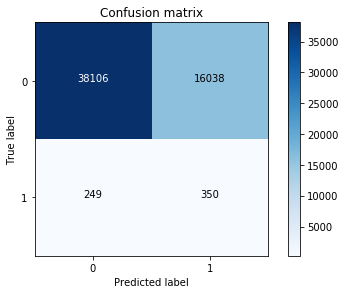

In [457]:
y_train_pre = lr1.predict(X_train)

cnf_matrix_tra = confusion_matrix(y_train, y_train_pre)

print("Recall metric in the train dataset: {}%".format(100*cnf_matrix_tra[1,1]/(cnf_matrix_tra[1,0]+cnf_matrix_tra[1,1])))
print("Precision metric in the testing dataset: {}%".format(100*cnf_matrix_tra[0,0]/(cnf_matrix_tra[0,0]+cnf_matrix_tra[1,0])))

class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix_tra , classes=class_names, title='Confusion matrix')
plt.show()

Recall metric in the testing dataset: 61.01083032490975%
Precision metric in the testing dataset: 99.42510380070266%
Accuracy metric in the testing dataset: 69.89689956979677%


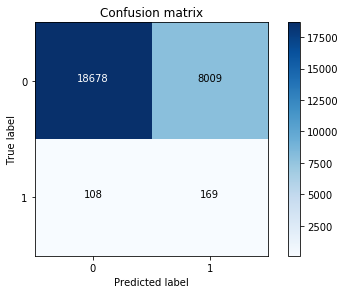

In [458]:
y_pre = lr1.predict(X_test)

cnf_matrix = confusion_matrix(y_test, y_pre)

print("Recall metric in the testing dataset: {}%".format(100*cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1])))
print("Precision metric in the testing dataset: {}%".format(100*cnf_matrix[0,0]/(cnf_matrix[0,0]+cnf_matrix[1,0])))
print("Accuracy metric in the testing dataset: {}%".format(100*(cnf_matrix[0,0] + cnf_matrix[1,1])/(cnf_matrix[0,0]+cnf_matrix[1,1]+cnf_matrix[0,1]+cnf_matrix[1,0])))
# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix , classes=class_names, title='Confusion matrix')
plt.show()

In [459]:
tmp = lr1.fit(X_train_res, y_train_res.ravel())

[LibLinear]

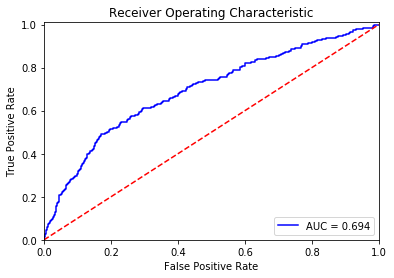

In [460]:
y_pred_sample_score = tmp.decision_function(X_test)


fpr, tpr, thresholds = roc_curve(y_test, y_pred_sample_score)

roc_auc = auc(fpr,tpr)

# Plot ROC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label='AUC = %0.3f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([0,1.0])
plt.ylim([0,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [234]:
scaler = StandardScaler()

In [235]:
X_std = scaler.fit_transform(X)

In [475]:
rf = RandomForestClassifier(n_estimators = 500, n_jobs=-1, oob_score=True, max_depth=3)

In [476]:
rf.fit(X_train_res, y_train_res)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

In [477]:
y_pred = rf.predict(X_test)

In [478]:
print(len(X_train_res))
print(len(y_train_res))
y_pred.sum()

108288
108288


9234.0

Recall metric in the train dataset: 60.60100166944908%
Precision metric in the training dataset: 99.34216027874564%
Accuracy metric in the training dataset: 65.76548599820981%


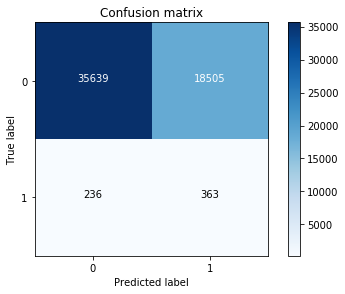

In [479]:
y_train_pre = rf.predict(X_train)

cnf_matrix_tra = confusion_matrix(y_train, y_train_pre)

print("Recall metric in the train dataset: {}%".format(100*cnf_matrix_tra[1,1]/(cnf_matrix_tra[1,0]+cnf_matrix_tra[1,1])))
print("Precision metric in the training dataset: {}%".format(100*cnf_matrix_tra[0,0]/(cnf_matrix_tra[0,0]+cnf_matrix_tra[1,0])))
print("Accuracy metric in the training dataset: {}%".format(100*(cnf_matrix_tra[0,0] + cnf_matrix_tra[1,1])/(cnf_matrix_tra[0,0]+cnf_matrix_tra[1,1]+cnf_matrix_tra[0,1]+cnf_matrix_tra[1,0])))

class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix_tra , classes=class_names, title='Confusion matrix')
plt.show()

Recall metric in the testing dataset: 64.62093862815884%
Precision metric in the testing dataset: 99.44726452340666%
Accuracy metric in the testing dataset: 66.0547396528705%


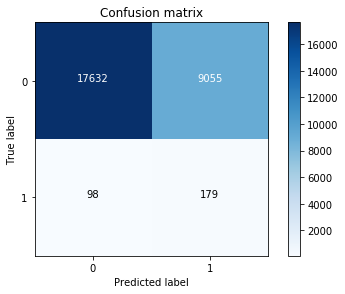

In [480]:
# y_pred = rf.predict(X_test)

cnf_matrix_rf = confusion_matrix(y_test, y_pred)

print("Recall metric in the testing dataset: {}%".format(100*cnf_matrix_rf[1,1]/(cnf_matrix_rf[1,0]+cnf_matrix_rf[1,1])))
print("Precision metric in the testing dataset: {}%".format(100*cnf_matrix_rf[0,0]/(cnf_matrix_rf[0,0]+cnf_matrix_rf[1,0])))
print("Accuracy metric in the testing dataset: {}%".format(100*(cnf_matrix_rf[0,0] + cnf_matrix_rf[1,1])/(cnf_matrix_rf[0,0]+cnf_matrix_rf[1,1]+cnf_matrix_rf[0,1]+cnf_matrix_rf[1,0])))
# {tp+tn}/{tp+tn+fp+fn}}
# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix_rf , classes=class_names, title='Confusion matrix')
plt.show()

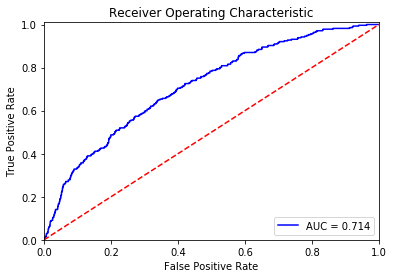

In [481]:
y_pred_sample_score_rf = rf.predict_proba(X_test)


fpr, tpr, thresholds = roc_curve(y_test, y_pred_sample_score_rf[:, 1])

roc_auc = auc(fpr,tpr)

# Plot ROC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label='AUC = %0.3f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([0,1.0])
plt.ylim([0,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [312]:
rf.predict_proba(X_test)[:, 1]

array([0.35143674, 0.59389331, 0.60145872, ..., 0.60210956, 0.52627459,
       0.30625065])

In [331]:
param_grid = {
    'max_depth': [2, 5],
    'max_features': [2, 3, 'auto'],
    
}

rf2 = RandomForestClassifier(n_estimators = 300, class_weight='balanced')
clf2 = GridSearchCV(rf2, param_grid, scoring='recall_weighted', cv=5, verbose=5, n_jobs=-1)
clf2.fit(X_train_res, y_train_res.ravel())

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] max_depth=2, max_features=2 .....................................
[CV] max_depth=2, max_features=2 .....................................
[CV] max_depth=2, max_features=2 .....................................
[CV] max_depth=2, max_features=2 .....................................
[CV] max_depth=2, max_features=2 .....................................
[CV] max_depth=2, max_features=3 .....................................
[CV] max_depth=2, max_features=3 .....................................
[CV] max_depth=2, max_features=3 .....................................
[CV] max_depth=2, max_features=3 .....................................
[CV] max_depth=2, max_features=3 .....................................
[CV] max_depth=2, max_features=auto ..................................
[CV] max_depth=2, max_features=auto ..................................
[CV]  max_depth=2, max_features=2, score=0.7667128987517337, total=  19.7s
[CV] max_dept

[Parallel(n_jobs=-1)]: Done  14 out of  30 | elapsed:  1.1min remaining:  1.3min


[CV]  max_depth=2, max_features=auto, score=0.7475265834489135, total=  44.9s
[CV] max_depth=5, max_features=auto ..................................
[CV]  max_depth=2, max_features=auto, score=0.7443828016643551, total=  45.3s
[CV] max_depth=5, max_features=auto ..................................
[CV]  max_depth=2, max_features=auto, score=0.746879334257975, total=  45.4s
[CV] max_depth=5, max_features=auto ..................................
[CV]  max_depth=5, max_features=2, score=0.8399907535829866, total=  39.6s
[CV] max_depth=5, max_features=auto ..................................
[CV]  max_depth=5, max_features=2, score=0.8349976883957466, total=  39.8s
[CV]  max_depth=5, max_features=2, score=0.8397133610725843, total=  39.9s
[CV]  max_depth=5, max_features=3, score=0.8548312528895053, total=  52.7s
[CV]  max_depth=5, max_features=3, score=0.8448451225150254, total=  53.0s


[Parallel(n_jobs=-1)]: Done  21 out of  30 | elapsed:  1.4min remaining:   37.0s


[CV]  max_depth=5, max_features=3, score=0.8478039759593158, total=  48.5s
[CV]  max_depth=5, max_features=3, score=0.8428571428571429, total=  48.8s
[CV]  max_depth=5, max_features=3, score=0.8539528432732316, total=  42.1s
[CV]  max_depth=5, max_features=auto, score=0.8637078132223763, total= 1.1min
[CV]  max_depth=5, max_features=auto, score=0.8704114655570966, total= 1.1min
[CV]  max_depth=5, max_features=auto, score=0.8756819232547388, total= 1.1min
[CV]  max_depth=5, max_features=auto, score=0.8756819232547388, total= 1.1min


[Parallel(n_jobs=-1)]: Done  28 out of  30 | elapsed:  2.3min remaining:    9.8s


[CV]  max_depth=5, max_features=auto, score=0.8704114655570966, total= 1.1min


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  2.3min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=300, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': [2, 5], 'max_features': [2, 3, 'auto']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='recall_weighted', verbose=5)

In [332]:
clf2.best_params_

{'max_depth': 5, 'max_features': 'auto'}

In [382]:
drop

['#days',
 '2b',
 '3b',
 'ab',
 'babip',
 'bf',
 'cs',
 'date',
 'days',
 'days_preceeding',
 'enddate',
 'era',
 'first_x',
 'first_y',
 'g',
 'gb/fb',
 'gdp',
 'gs',
 'ibb',
 'injury',
 'key_bbref_x',
 'key_bbref_y',
 'key_fangraphs_x',
 'key_fangraphs_y',
 'key_mlbam',
 'key_retro_x',
 'key_retro_y',
 'l',
 'last_x',
 'last_y',
 'ld',
 'lev',
 'list',
 'mlb_played_first_y',
 'mlb_played_last_x',
 'mlb_played_last_y',
 'moneyearned',
 'name_first_x',
 'name_first_y',
 'name_last_x',
 'name_last_y',
 'name_x',
 'name_y',
 'po',
 'posititon',
 'pu',
 'sb',
 'sf',
 'so/w',
 'startdate',
 'stl',
 'sts',
 'sv',
 'team',
 'tm',
 'year']

In [440]:
pro = X
# pro = pro.replace([np.inf, -np.inf], np.nan)
# pro['p_throws_x'] = pro['p_throws_x'].fillna(pro['p_throws_y'])
# pro = pro.drop(columns='p_throws_y')
# pro = pro.fillna(0)
pro = pro.drop(columns=drop_more)

In [439]:
# pro = total.drop(columns=drop)
drop_more = ['L', 'R', 'appearance_yr', 'ip', 'mlb_played_first_x', 'w', 'fb_percieved_speed', 'fb_avg_x', 'os_percieved_speed', 'os_avg_x']


In [441]:
pro['fb_count'] = pro['fb_count']/pro['pit']

In [442]:
pro['os_count'] = pro['os_count']/pro['pit']

In [446]:
pro = pro.replace([np.inf, -np.inf], np.nan)
pro = pro.fillna(0)

In [408]:
y = X.pop('injured?')

KeyError: 'injured?'

In [409]:
y

0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
5        0.0
6        0.0
7        0.0
8        0.0
9        0.0
10       0.0
11       0.0
12       0.0
13       0.0
14       0.0
15       0.0
16       0.0
17       0.0
18       0.0
19       0.0
20       0.0
21       0.0
22       0.0
23       0.0
24       0.0
25       0.0
26       0.0
27       0.0
28       0.0
29       0.0
30       0.0
31       0.0
32       0.0
33       0.0
34       0.0
35       0.0
36       0.0
37       0.0
38       0.0
39       0.0
40       0.0
41       0.0
42       0.0
43       0.0
44       0.0
45       0.0
46       0.0
47       0.0
48       0.0
49       0.0
50       0.0
51       0.0
52       0.0
53       0.0
54       0.0
55       0.0
56       0.0
57       0.0
58       0.0
59       0.0
60       0.0
61       0.0
62       0.0
63       0.0
64       0.0
65       0.0
66       0.0
67       0.0
68       0.0
69       0.0
70       0.0
71       0.0
72       0.0
73       0.0
74       0.0
75       0.0
76       0.0